# Tp3 : Mediciones de sensor de barrido láser 

1) Lanzamos Gazebo para simular el robot TurtleBot3 en el entorno mundo 

` roslaunch turtlebot3_gazebo turtlebot3_world.launch`

<img src="./imgs/turtlebot_world.png" alt="Gazebo" width="500" height = "500"/>

2) Lanzamos el nodo de teleoperación para mover el robot con el teclado 

` roslaunch turtlebot3_teleop turtlebot3_teleop_key.launch ` 

3) Ejecutamos la herramienta de registro de datos que crea un registro de odometría y puntos del sensor láser con extensión .bag . Rosbag permite grabar los mensajes de los tópicos que se le pasen por la línea de comandos

` rosbag record /cmd_vel /odom /scan ` 

En este caso, estaremos creando un registro del tópico de los **comando de velocidad**, de  **odometría** y **scan** que corresponde al sensor láser. 

El registro creado tiene de nombre **world.bag**


4) Descargamos el paquete de ROS para convertir el registro con extensión bag en texto plano. Para ello clonamos el repositorio en el espacio de trabajo de ROS (catkin_ws creado en práctico anteriores) 

```bash
    cd ~/catkin_ws/src  
    git clone https://github.com/ciiiutnfrc/rosbag2txt.git 
 ```   

  Después construimos el paquete con la herramienta `catkin_make`. Para comprobar que se ha construido exitosamente podemos corroborar: 
  
  ` rospack find rosbag2txt` 
  
 5) Convertimos el formato del archivo de texto: 
 
 `roslaunch rosbag2txt rosbag2txt.launch bagfile:=/home/<user>/world.bag`

   Realizamos ciertos **cambios** en el script por problemas de incompatibilidad con la versión de python en nuestra PC. 
 
 * La primer línea ` #!/usr/bin/env python` del script *odom_scan_log.py* la cambiamos por `#!/usr/bin/env python3 `. 
  
 * La línea 53 ` except rospy.ServiceException, e:` la cambiamos a ` except rospy.ServiceException as e:`

6) Cargamos los datos de scan.txt y graficamos 3 barridos laser 

In [2]:
import pandas as pd 
import matplotlib.pylab as plt
import numpy as np 

#El separador es un caracter de tab
# 
Scandata = pd.read_csv("./log/scan.txt", sep= "\t", 
                       header=None, index_col = None) 
Scandata = Scandata.replace(np.inf,3.5) #El inf lo reemplazo por el valor máxima 
puntos  =[]
puntos.append(Scandata.loc[0,1:])
puntos.append(Scandata.loc[1,1:])
puntos.append(Scandata.loc[2,1:])



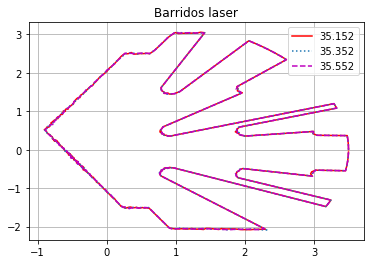

In [3]:
linea = ['r-', ':','m--']


plt.figure(1)
plt.title("Barridos laser")
plt.grid('true')
for j in range(len(puntos)):
    ax  = [] 
    ay = [] 
    for i,rho in enumerate(puntos[j]):
        res = 2*np.pi / 360 
        x = rho * np.cos(res*i)
        y = rho* np.sin(res*i)
        ax.append(x)
        ay.append(y)
   
    plt.plot(ax,ay,linea[j], label = Scandata.loc[j,0])
plt.legend()

Con ese gráfico comprobamos que 3 barridos laser consecutivos parecen no tener diferencia algunas. Ahora graficamos 3 barridos con una diferencia de tiempo significable 

In [4]:
puntos  =[]
puntos.append(Scandata.loc[0,1:])
puntos.append(Scandata.loc[len(Scandata)//2,1:])
puntos.append(Scandata.loc[len(Scandata)-1,1:])


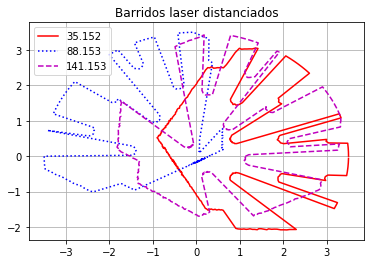

In [5]:
linea = ['r-', 'b:','m--']
time = [Scandata.loc[0,0], Scandata.loc[len(Scandata)//2,0],
        Scandata.loc[len(Scandata)-1,0]]

plt.figure(1)
plt.title("Barridos laser distanciados")
plt.grid('true')
for j in range(len(puntos)):
    ax  = [] 
    ay = [] 
    for i,rho in enumerate(puntos[j]):
        res = 2*np.pi / 360 
        x = rho * np.cos(res*i)
        y = rho* np.sin(res*i)
        ax.append(x)
        ay.append(y)
   
    plt.plot(ax,ay,linea[j], label = time[j])
plt.legend()

7) Diseñamos un algoritmo que determina los indices del vector de timestamp de odometría que se encuentran más proximos a los valoers del vector de timestamp de las mediciones laser. 

Esto se puede hacer de varias formas, de manera general : 

   * Buscar por todo el arreglo y encontrar el valor que más se acerca , y en el peor de los casos tomará N . Log(N) iteraciones
   * Usar particionamiento del arreglo, toma N iteraciones aproximadamente. 
   
La fomas más facil, aunque no la más rapida es con las funciones de panda, trabajando con dataFrames. De todo el arreglo restamos el valor, lo convertimos a absoluto y devolvemos el indice del mínimo encontrado.

In [125]:
def encontrar_valorCercano(valor,df):
    return (df[0].sub(valor).abs().idxmin())

Cargamos los datos de **odometría** y recorremos todo el arreglo de los timestamp del barrido laser

In [140]:
Odomdata = pd.read_csv("./log/odom.txt", sep= "\t", 
                       header=None, index_col = None) 
near_i = []

for timestamp in Scandata[0]:
    near_i.append( encontrar_valorCercano(timestamp,Odomdata))

near_i = np.array(near_i)

8) Para mostar las cercanias de los valores de timestamp graficamos algunos puntos de ambos vectores. 

* Graficamos N = 10 puntos de tiempo del sensor laser 
* Graficamos los puntos de tiempo de odometría hasta el valor más cercano al elemento N del laser 
* Solo graficamos los puntos de odometria pares para no tener varios amontonados 
* Si el punto de odometría a graficar corresponde con elemento cercano al timestamp de laser graficamos un cuadrado. 

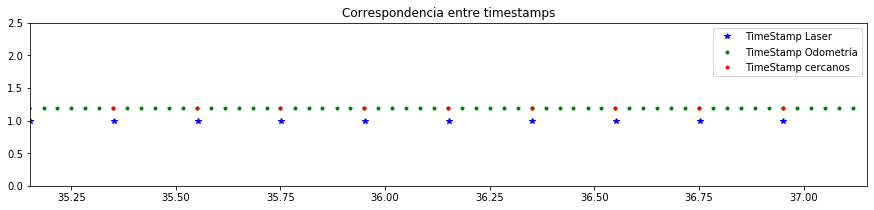

In [157]:
N=10
plt.figure(figsize=(15, 3))
plt.title("Correspondencia entre timestamps")

plt.xlim(Scandata[0][0], Scandata[0][N])
plt.ylim(0,2.5)

plt.plot(Scandata[0][0:N],np.ones(N),linestyle="", 
         marker = '*',color = "blue", 
         label = "TimeStamp Laser" )

plt.plot(Odomdata[0][0:near_i[N]],1.2*np.ones(near_i[N]),
         linestyle="",marker = '.', color = "green",
         label = "TimeStamp Odometría")

plt.plot(Odomdata[0][near_i[(near_i < near_i[N])]], # N puntos de laser que corresponden 
         1.2*np.ones(N),linestyle="",marker = '.',  # con los N puntos de cercania
         color = "red", label = "TimeStamp cercanos")


plt.legend()
plt.savefig("./imgs/fig_correspondencia_timestamps.png")


9) Graficamos la nube de puntos del sensor laser en el mapa, con respeto al centro odométrico del robot 

* Construimos una función para pasar de coordenadas polares a rectangulares como la utilizada anteriormente 

In [164]:
def polar2rec(rho,theta):    #Rho, Tita --> (x,y)
   
    x = rho * np.cos(theta)
    y = rho* np.sin(theta)
    return x,y

    
def Polars2Recs(res,vec):   #Vec con coord polares a vec con cord rec 
    Xcord = []
    Ycord = []
    for i,rho in enumerate(vec):
        theta = res*i 
        x,y =  polar2rec(rho,theta)
        Xcord.append(x)
        Ycord.append(y) 
    return X,Y

In [169]:
laser_rec  = [np.zeros(len(Scandata[0])),[]]  #matriz con coorden